In [1]:
# Load libraries
import numpy as np
from numpy.linalg import inv 
import scipy as sp
import pandas as pd
import os
os.environ["MKL_THREADING_LAYER"] = "GNU"

# Plotting libarires
import plotnine as pn
from plotnine import *
import corner 

# Importing pymc3
import pymc3 as pm

# Supressing warnings
import warnings
warnings.filterwarnings("ignore")
# warnings.filterwarnings("default")

### Lodaing the data

In [2]:
count_data = pd.read_csv('change_point1.csv').rename({'x':'time','y':'observed_counts'},axis=1)
count_data.head()

,time,observed_counts
0,1,2
1,2,4
2,3,4
3,4,4
4,5,6


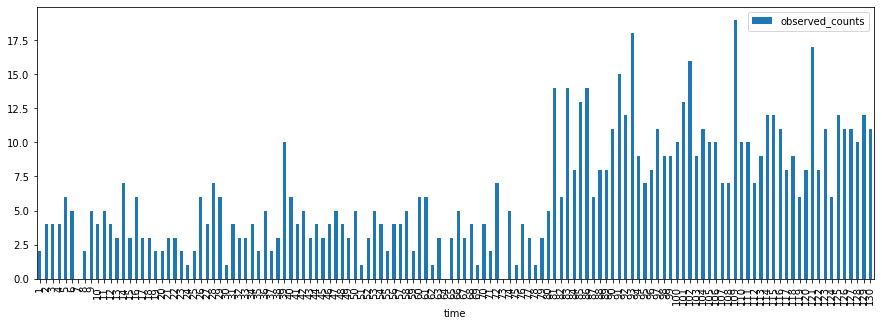

In [3]:
# Visualize the data
count_data.plot(x = 'time', y ='observed_counts',  kind = 'bar', figsize=(15,5))

It is hard to see in the graph when the change took place. 

### Building the model

In [4]:
# Setting up constants
mean_of_counts = count_data.observed_counts.mean()
alpha = 1.0/mean_of_counts
l = len(count_data)

In [5]:
# - Defining the base stochastic parameters in the model - 
model = pm.Model()

with model:

    lambda_1 = pm.Exponential('lambda_1',alpha)
    lambda_2 = pm.Exponential('lambda_2',alpha)

    tau = pm.DiscreteUniform('tau',lower = 0, upper= l-1)

In [6]:
# - Defining how lambda switches - 
with model:
    idx = count_data.time
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2) # This is a deterministic function

In [7]:
# - Relating our data to the model -
with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data.observed_counts)

In [8]:
# - Running sampler -
chains = 4
samples = 10000

with model:
    step = pm.Metropolis()
    trace = pm.sample(draws = samples, 
                      chains = chains, 
                      tune=5000,
                      step=step)

Multiprocess sampling (4 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 4 chains, 0 divergences: 100%|█████████████████████████████████████| 60000/60000 [00:51<00:00, 1175.28draws/s]
The number of effective samples is smaller than 25% for some parameters.


### What does the distribution of our parameters look like?

In [9]:
# - Posterior values -
lambda_1_samples =  trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

# - Posterior distribution -
posterior_dist = pd.DataFrame({'lambda_1': lambda_1_samples, 'lambda_2': lambda_2_samples, 'tau' : tau_samples})
posterior_dist = posterior_dist.unstack().reset_index()
posterior_dist = posterior_dist.rename(columns = {'level_0':'Parameter',
                                                  'level_1':'Sample',
                                                  0:'simulated_parameter'})

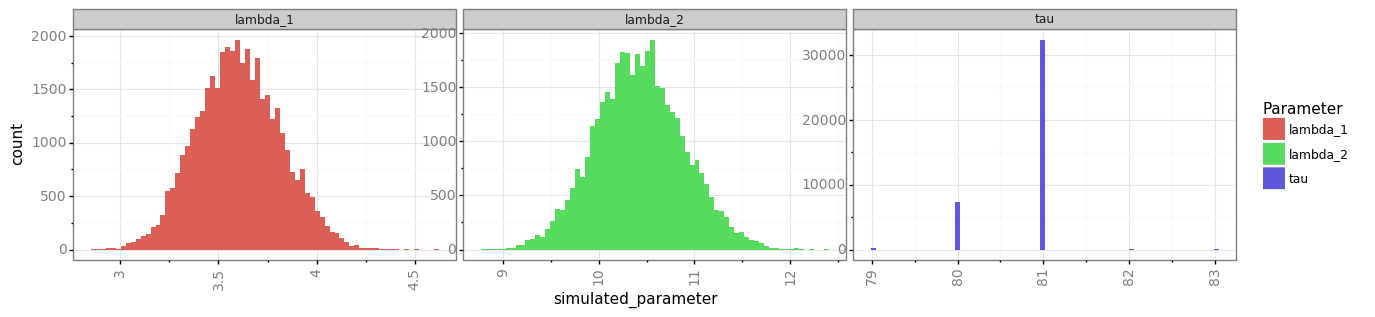

<ggplot: (107317136346)>

In [10]:
# Plot options
pn.options.figure_size = (15,3)
pn.options.dpi = 100

# Plotting distribution
ggplot(aes(x = 'simulated_parameter', fill = 'Parameter'), data = posterior_dist)\
+ geom_histogram(bins = 70)\
+ facet_wrap(['Parameter'],scales='free')\
+ theme_bw()\
+ theme(axis_text_x = element_text(color="grey", size=10, angle=90, hjust=.5),
        axis_text_y = element_text(color="grey", size=10))

### What are good estimates for switch point?

In [11]:
# Rounding to nearest 100th
posterior_dist['simulated_parameter'] = np.round(posterior_dist['simulated_parameter'],2)

# Getting MAP estimates of simulated values
MAP_estimates = posterior_dist.groupby('Parameter').simulated_parameter.agg(pd.Series.mode)

# Getting the summarized values
out = '''
---------------------------------------------------------------------
The MAP estimate for the switch point is at {switch_point_time}.
The MAP estimate for the rate BEFORE the switch point is {lambda_1}.
The MAP estimate for the rate AFTER the switch point is {lambda_2}.
---------------------------------------------------------------------
'''.format(switch_point_time = MAP_estimates.tau,
          lambda_1 = MAP_estimates.lambda_1,
          lambda_2 = MAP_estimates.lambda_2,)
print(out)
# pm.find_MAP(model=model)


---------------------------------------------------------------------
The MAP estimate for the switch point is at 81.0.
The MAP estimate for the rate BEFORE the switch point is 3.56.
The MAP estimate for the rate AFTER the switch point is 10.26.
---------------------------------------------------------------------

